# Trufl
> Optimizing adaptive sampling using Multiple-criteria decision-making

**Trufl** was initiated in the context of the [IAEA (International Atomic Energy Agency)](https://www.iaea.org) Coordinated Research Project titled ["Monitoring and Predicting Radionuclide Uptake and Dynamics for Optimizing Remediation of Radioactive Contamination in Agriculture"](https://www.iaea.org/newscenter/news/new-crp-monitoring-and-predicting-radionuclide-uptake-and-dynamics-for-optimizing-remediation-of-radioactive-contamination-in-agriculture-crp-d15019).

While **Trufl** was originally developed to address the remediation of farmland affected by nuclear accidents, its approach and algorithms are **applicable to a wide range of application domains**. This includes managing **legacy contaminants or monitoring any phenomenon that requires consideration of multiple decision criteria**, potentially involving a large set of data.

This package leverages the work done by [Floris Abrams](https://www.linkedin.com/in/floris-abrams-59080a15a) in the context of his PhD at [KU Leuven](https://www.kuleuven.be) and [Franck Albinet](https://www.linkedin.com/in/franckalbinet), International Consultant in Geospatial Data Science and currently PhD researcher in AI applied to nuclear remedation at KU Leuven.


## Install

`pip install trufl`

## Getting started

In highly sensitive and high-stakes situations, it is **essential that decision making is informed, transparent, and accountable**, with decisions being based on a thorough and objective analysis of the available data and the needs and concerns of affected communities being taken into account.

Given the time constraints and limited budgets that are often associated with data surveys (in particular ones supposed to informed highligh sensitive situation), it is **crucial to make informed decisions about how to allocate resources**. This is even more important when considering the many variables that can be taken into account, such as prior knowledge of the area, health and economic impacts, land use, whether remediation has already taken place, population density, and more. Our approach leverages Linear Programming techniques such as **Multiple-criteria decision-making** to optimize the data survey workflow:

In this demo, we will walk you through a **typical workflow** using the `Trufl` package. To help illustrate the process, we will use a "toy" dataset that represents a typical spatial pattern of soil contaminants.

1. We **assume that we have access to the ground truth**, which is a raster file that shows the spatial distribution of a soil contaminant;
2. We will make decisions about how to sample and how much at **administrative units**, which in this case are **simulated as a grid** (using the `gridder` utilities function);
3. Based on prior knowledge of the phenomenon of interest, such as prior airborne surveys or other data, an `Optimizer` will **rank each grid cell according to its priority for sampling**;
4. We will then **perform random sampling on the designated grid cells** (using a `Sampler`). To simulate the measurement process, we will use the ground truth to emulate measurements at each location (using a `DataCollector`);
5. We will **evaluate the new state of each cell based on the measurements** and **pass it to a new round of optimization**. This process will be repeated iteratively to refine the sampling strategy.

In [ ]:
#| hide
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd

from trufl.utils import gridder
from trufl.sampler import Sampler
from trufl.collector import DataCollector
from trufl.callbacks import (State, MaxCB, MinCB, StdCB, CountCB, MoranICB, PriorCB)
from trufl.optimizer import Optimizer

red, black = '#BF360C', '#263238'

### Our simulated ground truth

The assumed ground truth reveals a typical spatial pattern of contaminant such as `Cs137` after a nuclear accident for instance.

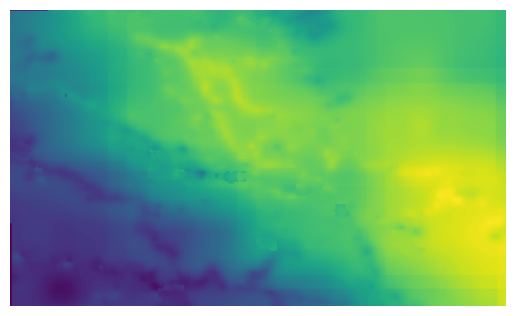

In [ ]:
fname_raster = './files/ground-truth-01-4326-simulated.tif'
with rasterio.open(fname_raster) as src:
    plt.axis('off')
    plt.imshow(src.read(1))

### Simulate administrative units

The sampling strategy will be determined on a per-grid-cell basis within the administrative unit. We define below a 10 x 10 grid over the area of interest:

In [ ]:
gdf_grid = gridder(fname_raster, nrows=10, ncols=10)
gdf_grid.head()

,geometry
loc_id,
0,"POLYGON ((-1.20830 43.26950, -1.20830 43.26042..."
1,"POLYGON ((-1.20830 43.27858, -1.20830 43.26950..."
2,"POLYGON ((-1.20830 43.28766, -1.20830 43.27858..."
3,"POLYGON ((-1.20830 43.29673, -1.20830 43.28766..."
4,"POLYGON ((-1.20830 43.30581, -1.20830 43.29673..."


:::{.callout-tip}

Note how each administrative unit is uniquely identified by its `loc_id`.

:::

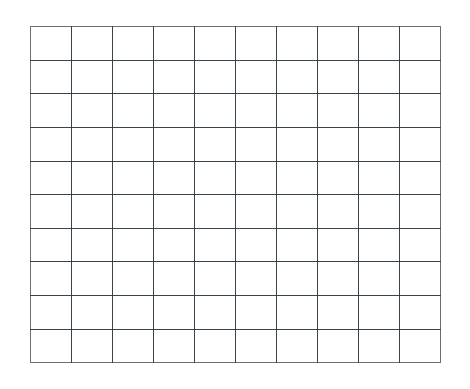

In [ ]:
gdf_grid.boundary.plot(color=black, lw=0.5)
plt.axis('off');

### What prior knowledge do we have?

At the initial time $t_0$, data sampling has not yet begun, but we can often **leverage existing prior knowledge of our phenomenon** of interest to inform our sampling strategy/policy. In the context of nuclear remediation, this prior knowledge can often be obtained through mobile surveys, such as airborne or carborne surveys, which can provide a **coarse estimation** of soil contamination levels.

In the example below, we **simulate prior information about the soil property of interest by calculating the average value of the property over each grid cell**.

At this stage, we have no measurements, so we simply create an empty [Geopandas GeoDataFrame](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.html). 

In [ ]:
samples_t0 = gpd.GeoDataFrame(index=pd.Index([], name='loc_id'), 
                              geometry=None, data={'value': None})

:::{.callout-tip}

We need to set an index `loc_id` and have a `geometry` and `value` columns.

:::

Now we get/"sense" the state of our grid cells based on the simulated prior (Mean over each grid cell `PriorCB`):

In [ ]:
state = State(samples_t0, gdf_grid, cbs=[PriorCB(fname_raster)])

# You have to call the instance
state_t0 = state(); state_t0.head()

,Prior
loc_id,
0,0.102492
1,0.125727
2,0.161802
3,0.184432
4,0.201405


:::{.callout-tip}

We get the `Prior` for each individual `loc_id` (here only the first 5 shown). The current `State` is only composed of a single `PriorCB` variable but can include many more variables as we will see below. 

:::

### Optimize sampling based on prior at $t_0$

In [ ]:
# Bugs?
#   - fails when ran twice
#   - `rank` is already a method of a pandas dataframe

benefit_criteria = [True]
optimizer = Optimizer(state=state_t0)
df_rank = optimizer.rank(is_benefit_x=benefit_criteria, w_vector = [1],  
                         n_method=None, c_method = None, 
                         w_method=None, s_method="CP")

df_rank.head()

,rank
loc_id,
92,1
93,2
91,3
94,4
82,5


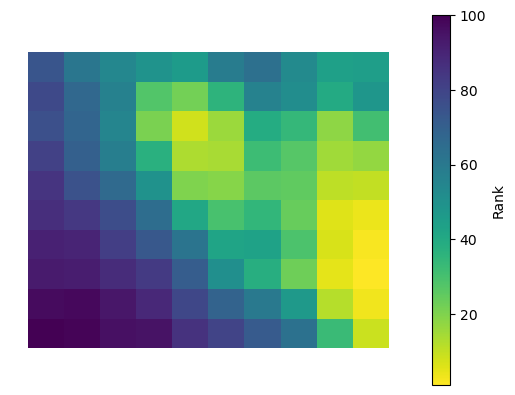

In [ ]:
gdf_grid.join(df_rank, how='left').plot(column='rank',
                                        cmap='viridis_r', 
                                        legend_kwds={'label': 'Rank'}, 
                                        legend=True)
plt.axis('off');

### Start sampling

:::{.callout-tip}

It's worth noting that in the absence of any prior knowledge, a uniform sampling strategy over the area of interest may be used. However, this approach may not be the most efficient use of the available data collection and analysis budget.

:::

WIP ...

In [ ]:
ranks = df_rank['rank'].sort_index().values; ranks

array([100,  97,  93,  91,  87,  85,  81,  76,  78,  74,  99,  98,  92,
        90,  84,  75,  70,  68,  67,  61,  96,  94,  88,  82,  77,  66,
        58,  55,  57,  54,  95,  89,  83,  73,  65,  50,  37,  21,  28,
        49,  86,  79,  71,  62,  41,  20,  13,   8,  22,  46,  80,  69,
        51,  42,  30,  19,  14,  16,  36,  59,  72,  60,  38,  43,  35,
        26,  32,  39,  56,  64,  63,  47,  23,  29,  24,  25,  27,  34,
        52,  53,  33,  12,   5,   7,   6,  11,  15,  18,  40,  44,   9,
         3,   1,   2,   4,  10,  17,  31,  48,  45])

In [ ]:
ranks.sum()

5050

In [ ]:
df_rank['rank'].sum()

5050

Generating a random set of points within a given:
- a geodataframe of polygons of interest (in this example just a grid with `loc_id`s);
- For each subarea (`loc_id`), we specify the number of measurements to be taken, which we simulate here by generating random numbers.

In [ ]:
sample_locs

,geometry
loc_id,
0,"MULTIPOINT ((-1.22206 43.26132), (-1.21164 43...."
1,"MULTIPOINT ((-1.22202 43.27012), (-1.22105 43...."
2,"MULTIPOINT ((-1.22306 43.28557), (-1.22286 43...."
3,"MULTIPOINT ((-1.22268 43.29206), (-1.22066 43...."
4,"MULTIPOINT ((-1.22330 43.29855), (-1.22229 43...."
...,...
95,"MULTIPOINT ((-1.08322 43.31068), (-1.08257 43...."
96,"MULTIPOINT ((-1.08652 43.32002), (-1.08610 43...."
97,"MULTIPOINT ((-1.08501 43.32808), (-1.08430 43...."


                                                 geometry
loc_id                                                   
0       MULTIPOINT ((-1.22206 43.26132), (-1.21164 43....
1       MULTIPOINT ((-1.22202 43.27012), (-1.22105 43....
2       MULTIPOINT ((-1.22306 43.28557), (-1.22286 43....
3       MULTIPOINT ((-1.22268 43.29206), (-1.22066 43....
4       MULTIPOINT ((-1.22330 43.29855), (-1.22229 43....


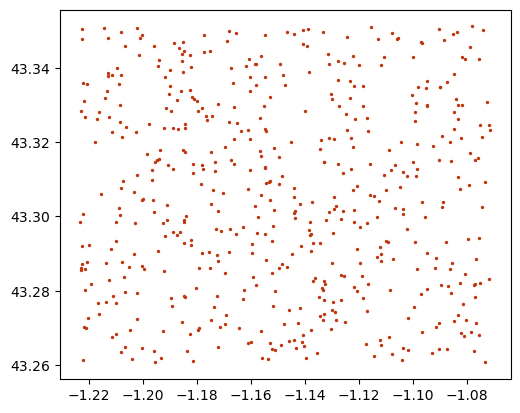

In [ ]:
sampler = Sampler(gdf_grid)
n = np.random.randint(1, high=10, size=len(gdf_grid), dtype=int)

sample_locs = sampler.sample(n, method='uniform')
print(sample_locs.head())
sample_locs.plot(markersize=2, color=red);

### Emulating data collection

With random sampling location defined, data collector should be to the field to take measurements. In our case, we "emulate" this process by "extracting" measurements from provided raster file.

We will emulate data collection from the raster shown below:

"Measuring" variable of interest from a given raster:

                         geometry     value
loc_id                                     
0       POINT (-1.22206 43.26132)  0.136230
0       POINT (-1.21164 43.26753)  0.079168
0       POINT (-1.21018 43.26824)  0.070453
1       POINT (-1.22202 43.27012)  0.107986
1       POINT (-1.22105 43.26999)  0.125664


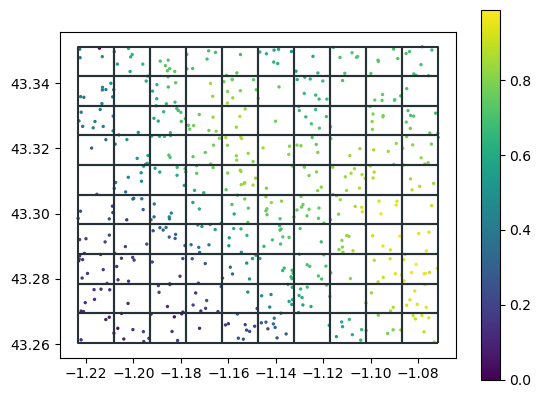

In [ ]:
dc_emulator = DataCollector(fname_raster)
samples_t0 = dc_emulator.collect(sample_locs)

print(samples_t0.head())
ax = samples_t0.plot(column='value', s=2, legend=True)
gdf_grid.boundary.plot(color=black, ax=ax);

### Getting current state

In [ ]:
state = State(samples_t0, gdf_grid, cbs=[
    MaxCB(), MinCB(), StdCB(), CountCB(), MoranICB(k=5), PriorCB(fname_raster)
])

# You have to call the instance
state_t0 = state(); state_t0

,Max,Min,Standard Deviation,Count,Moran.I,Prior
loc_id,,,,,,
0,0.145231,0.074017,0.025631,8,0.915078,0.102492
1,0.152964,0.111763,0.015033,7,0.679907,0.125727
2,0.160229,0.160229,0.000000,1,NaN,0.161802
3,0.188177,0.164264,0.008248,6,0.940746,0.184432
4,0.261005,0.241690,0.009657,2,NaN,0.201405
...,...,...,...,...,...,...
95,0.877876,0.800729,0.027397,5,NaN,0.803670
96,0.804376,0.795942,0.004217,2,NaN,0.763408
97,0.799064,0.672111,0.047581,8,0.948441,0.727797


## Build the ranking of polygons based on several criteria

### Criteria
- MaxCB()
- MinCB()
- StdCB()
- CountCB()
- MoranICB(k=5) -- Gives 2 values (value , p-value)
- PriorCB

### Criteria type 
- Benefit (high values --> high score --> rank high --> prioritized sampling needed)
- Cost (high values --> low score --> low high --> Less sampling needed)

- MaxCB() -- Benefit
- MinCB() -- ???
- StdCB() -- Benefit
- CountCB() -- Cost (Low count -- higher priority because more samples need)
- MoranICB(k=5) -- Cost (high value -- highly correlated -- less need for sampling ?? )
- PriorCB -- Benefit

### MCDM techniques
- CP -- low values -- good alternative
- TOPSIS -- High Value -- good alternative

! Everything is converted to rank to account for these differences ! 


In [ ]:
benefit_criteria = [True, True, True]
state = State(samples_t0, gdf_grid, cbs=[MaxCB(), MinCB(), StdCB()])

In [ ]:
optimizer = Optimizer(state=state())
df = optimizer.rank(is_benefit_x=benefit_criteria, w_vector = [0.3, 0.3, 0.4],  
                    n_method=None, c_method = None, w_method=None, s_method="CP")

df.head()

,rank
loc_id,
93,1
92,2
84,3
91,4
83,5


In [ ]:
# https://kapernikov.com/ipywidgets-with-matplotlib/